In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install joblib
!pip install streamlit


In [2]:
import pandas as pd
import numpy as np
import os

# Load raw data
df = pd.read_csv('../data/raw/diabetes.csv')

# Check for 0s in medically impossible columns
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_with_zero] = df[cols_with_zero].replace(0, np.nan)

# Fill missing values with median
df.fillna(df.median(), inplace=True)

# Save cleaned data
os.makedirs('../data/processed/', exist_ok=True)
df.to_csv('../data/processed/diabetes_cleaned.csv', index=False)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


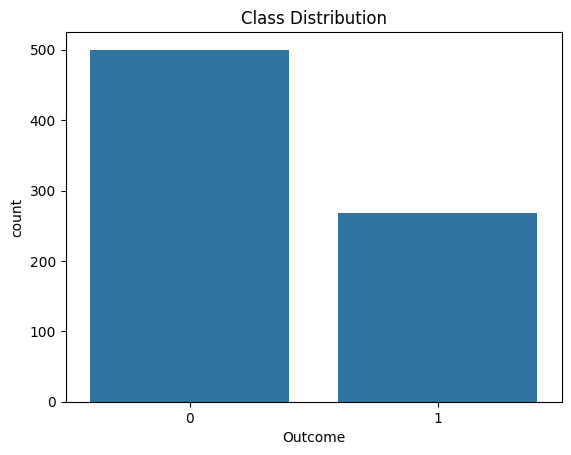

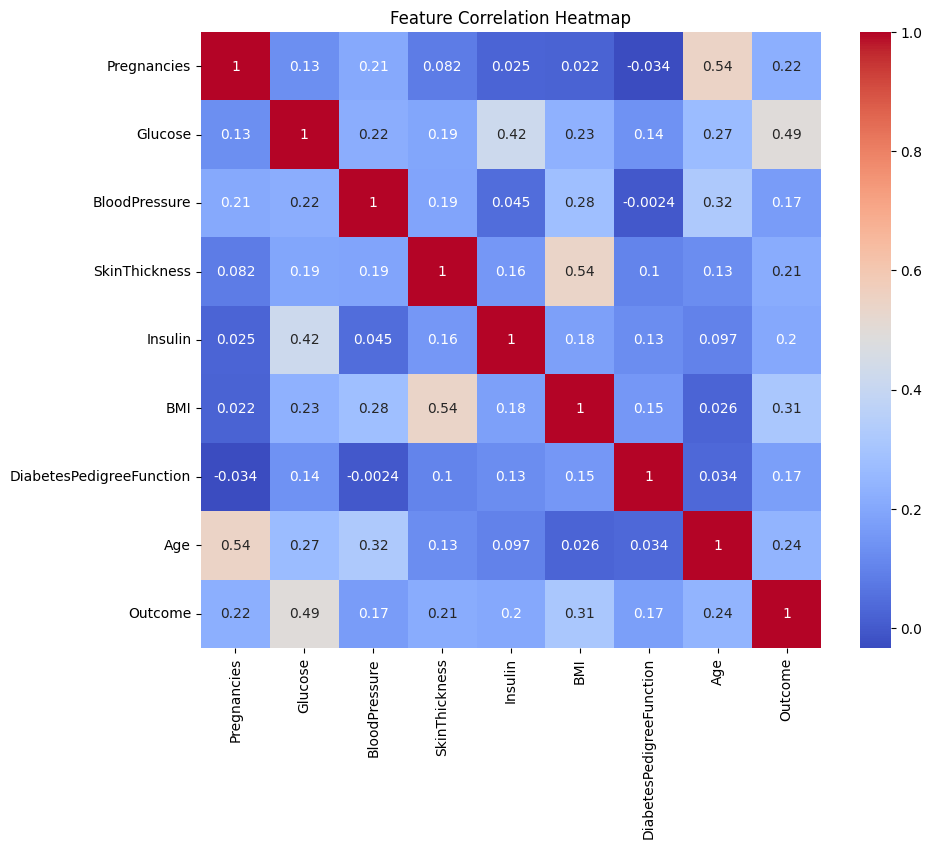

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/diabetes_cleaned.csv')

# Class distribution
sns.countplot(x='Outcome', data=df)
plt.title("Class Distribution")
plt.savefig('../outputs/figures/class_distribution.png')

# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig('../outputs/figures/correlation_heatmap.png')


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import os

# Load data
df = pd.read_csv('../data/processed/diabetes_cleaned.csv')

# Features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForest': RandomForestClassifier(),
    'DecisionTree': DecisionTreeClassifier()
}

os.makedirs('../outputs/metrics/', exist_ok=True)
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    joblib.dump(model, f'../outputs/metrics/{name}_model.pkl')

joblib.dump(scaler, '../outputs/metrics/scaler.pkl')


['../outputs/metrics/scaler.pkl']


=== LogReg ===
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       500
           1       0.71      0.57      0.63       268

    accuracy                           0.77       768
   macro avg       0.75      0.72      0.73       768
weighted avg       0.76      0.77      0.76       768

AUC: 0.841

=== RandForest ===
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       500
           1       0.92      0.93      0.93       268

    accuracy                           0.95       768
   macro avg       0.94      0.94      0.94       768
weighted avg       0.95      0.95      0.95       768

AUC: 0.984


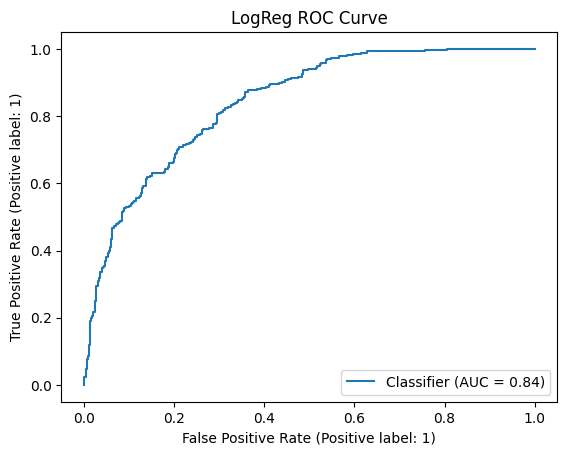

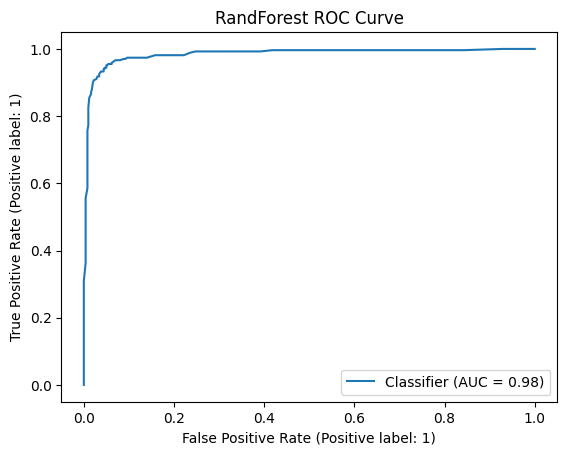

In [18]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Load models
log_model = joblib.load('../outputs/metrics/LogisticRegression_model.pkl')
rf_model = joblib.load('../outputs/metrics/RandomForest_model.pkl')
scaler = joblib.load('../outputs/metrics/scaler.pkl')

# Load data
df = pd.read_csv('../data/processed/diabetes_cleaned.csv')
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_scaled = scaler.transform(X)

# Evaluate
for model_name, model in [('LogReg', log_model), ('RandForest', rf_model)]:
    y_pred = model.predict(X_scaled)
    y_prob = model.predict_proba(X_scaled)[:,1]
    
    print(f"\n=== {model_name} ===")
    print(classification_report(y, y_pred))
    print(f"AUC: {roc_auc_score(y, y_prob):.3f}")

    RocCurveDisplay.from_predictions(y, y_prob)
    plt.title(f'{model_name} ROC Curve')
    plt.savefig(f'../outputs/figures/{model_name}_ROC.png')


# src/app.py

import streamlit as st
import pandas as pd
import joblib

# Load the saved model and scaler
model = joblib.load('../outputs/metrics/LogisticRegression_model.pkl')
scaler = joblib.load('../outputs/metrics/scaler.pkl')

st.title("🩺 Diabetes Risk Prediction")

st.write("Enter your health metrics below:")

# Input form
glucose = st.number_input("Glucose", min_value=0, max_value=200, value=100)
blood_pressure = st.number_input("Blood Pressure", min_value=0, max_value=122, value=70)
bmi = st.number_input("BMI", min_value=0.0, max_value=70.0, value=25.0)
insulin = st.number_input("Insulin", min_value=0, max_value=846, value=80)
age = st.slider("Age", min_value=21, max_value=100, value=33)

if st.button("Predict"):
    # Build DataFrame from inputs
    input_df = pd.DataFrame([[glucose, blood_pressure, bmi, insulin, age]],
                            columns=['Glucose', 'BloodPressure', 'BMI', 'Insulin', 'Age'])
    
    # Preprocess
    input_scaled = scaler.transform(input_df)

    # Predict
    prediction = model.predict(input_scaled)[0]
    if prediction == 1:
        st.error("⚠️ High risk of Diabetes")
    else:
        st.success("✅ Low risk of Diabetes")
